# How to process and use the splatter simulated data

Make folds and whatnot

In [1]:
import numpy as np
import pandas as pd

In [2]:
import sys
sys.path.append('/home/ahsvargo/xvalid')

In [3]:
from picturedrocks import Rocks
from picturedrocks.performance import FoldTester, PerformanceReport, NearestCentroidClassifier

In [4]:
import plotly.graph_objs as go
from plotly.offline import plot, iplot, init_notebook_mode

In [5]:
init_notebook_mode(connected=True)

In [6]:
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()

scanpy==1.3.7+56.gde16b79.dirty anndata==0.6.11 numpy==1.14.6 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.0 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [7]:
import anndata

### Zheng Simulated

## The full gene set

In [9]:
path = "/home/ahsvargo/turbo/scData/zheng17/splatter-bCells/allGenes/"

In [12]:
X = np.loadtxt(path + "counts.dat", dtype='int').T
y = np.loadtxt(path + "y.dat", dtype='int')
y = y - 1

ValueError: invalid literal for int() with base 10: '"Cell1"'

In [12]:
import scipy.sparse as spsp

Do the whole filtering procedure for all 10 datasets - see below for filtering an individual data set

In [15]:

for i in range(1,10):
    currPath = path + str(i) + "/"
    print("Current path is:" + currPath)
    
    print("Loading counts data", flush=True)
    X = np.loadtxt(currPath + "counts.dat", dtype='int').T
    y = np.loadtxt(currPath + "y.dat", dtype='int')
    y = y - 1
    
    print("Data loaded... sparsifying...", end =" ")
    sX = spsp.coo_matrix(X)
    sX.eliminate_zeros()
    sX = sX.tocsr()
    
    # save the sparse data
    spsp.save_npz(currPath + "sparseCounts", sX)
    print("Sparse data saved", flush=True)
    
    print("Filtering to find top variable genes")
    # filter the genes to find the top 5000 most variable
    adata = anndata.AnnData(X=sX)
    sc.pp.filter_genes(adata, min_counts=1)  # only consider genes with more than 1 count
    sc.pp.normalize_per_cell(adata)          # normalize with total UMI count per cell
    
    filter_result = sc.pp.filter_genes_dispersion(
        adata.X, 
        flavor='cell_ranger', 
        n_top_genes=5000, 
        log=False
    )
    sc.logging.print_memory_usage()
    
    print("Saving filtered subset")
    # the full dataset
    adata = anndata.AnnData(X = sX)
    sc.pp.filter_genes(adata, min_counts=1)      # only consider genes with more than 1 count
    adata = adata[:, filter_result.gene_subset]  # filter genes
    
    # save the data from the filtered genes
    adata.write(currPath + "filtered-splat.h5ad")
    
    print("Saving info about DE genes in the filtered subset")
    # also save information about the DE genes that remain
    genesRemain = [int(gene) for gene in adata.var.index]
    deInfo = np.loadtxt(currPath + "deGenes.dat")
    genes = np.array([gene for gene in deInfo[:,0].astype(int) if gene in genesRemain])
    args = [ np.where(deInfo[:,0] == gene)[0] for gene in genes ]
    facs = deInfo[:,1][args].flatten()
    
    print("{} genes out of 5000 are still DE after filtering".format(facs.shape[0]))
    np.savez(currPath + "filtered-splat-deInfo", genes=genes, facs=facs)
    

Current path is:/home/ahsvargo/turbo/scData/zheng17/splatter-bCells/allGenes/1/
Loading counts data
Data loaded... sparsifying... Sparse data saved
Filtering to find top variable genes
filtered out 3718 genes that are detected in less than 1 counts
Memory usage: current 2.04 GB, difference +0.01 GB
Saving filtered subset
filtered out 3718 genes that are detected in less than 1 counts
Saving info about DE genes in the filtered subset
497 genes out of 5000 are still DE after filtering
Current path is:/home/ahsvargo/turbo/scData/zheng17/splatter-bCells/allGenes/2/
Loading counts data
Data loaded... sparsifying... Sparse data saved
Filtering to find top variable genes
filtered out 3466 genes that are detected in less than 1 counts
Memory usage: current 2.04 GB, difference -0.00 GB
Saving filtered subset
filtered out 3466 genes that are detected in less than 1 counts
Saving info about DE genes in the filtered subset
534 genes out of 5000 are still DE after filtering
Current path is:/home/ah

In [25]:
sX = spsp.coo_matrix(X)
sX.eliminate_zeros()
sX = sX.tocsr()

In [26]:
spsp.save_npz(path + "sparseCounts", sX)

In [27]:
data = Rocks(sX,y)
ft = FoldTester(data)
ft.loadfolds(path + "bCells-5folds.npz")

ft.makerocks(verbose=0)

0

We also need folds for each of the 10 datasets, since the y vector is different for each one.   We also may as well use different folds... this is probably closer to the point of fold testing.  You shouldn't run this more than once.

In [19]:
%%time
for i in range(10):
    currPath = path + str(i) + "/"
    print("Current path is:" + currPath)
    
    sX = spsp.load_npz(currPath + "sparseCounts.npz")
    y = np.loadtxt(currPath + "y.dat", dtype='int')
    y = y - 1
    
    data = Rocks(sX,y)
    ft = FoldTester(data)
    #ft.makefolds(5, random=True)
    #ft.savefolds(currPath + "bCells-5folds.npz")

Current path is:/home/ahsvargo/turbo/scData/zheng17/splatter-bCells/allGenes/0/
Current path is:/home/ahsvargo/turbo/scData/zheng17/splatter-bCells/allGenes/1/
Current path is:/home/ahsvargo/turbo/scData/zheng17/splatter-bCells/allGenes/2/
Current path is:/home/ahsvargo/turbo/scData/zheng17/splatter-bCells/allGenes/3/
Current path is:/home/ahsvargo/turbo/scData/zheng17/splatter-bCells/allGenes/4/
Current path is:/home/ahsvargo/turbo/scData/zheng17/splatter-bCells/allGenes/5/
Current path is:/home/ahsvargo/turbo/scData/zheng17/splatter-bCells/allGenes/6/
Current path is:/home/ahsvargo/turbo/scData/zheng17/splatter-bCells/allGenes/7/
Current path is:/home/ahsvargo/turbo/scData/zheng17/splatter-bCells/allGenes/8/
Current path is:/home/ahsvargo/turbo/scData/zheng17/splatter-bCells/allGenes/9/
CPU times: user 1.55 s, sys: 44 ms, total: 1.59 s
Wall time: 2.17 s


In [13]:
#making the original folds.... don't run this if not commented
#ft.makefolds(5, random=True)
#ft.savefolds(path + "bCells-5folds.npz")

In [9]:
# the full dataset
adata = anndata.AnnData(X = X)
adata.obs['zhengsim_clusters'] = pd.Series(y, dtype="category", index=adata.obs.index)

In [10]:
folds = ft.folds
dataset = "zhengsim"
lookup = [ str(a) for a in np.unique(y)]

NameError: name 'ft' is not defined

## The filtered gene set

In [10]:
path = "/home/ahsvargo/turbo/scData/zheng17/splatter-bCells/filtered/"

In [ ]:
X = np.loadtxt(path + "counts.dat", dtype='int').T
y = np.loadtxt(path + "y.dat", dtype='int')
y = y - 1

In [17]:
data = Rocks(X,y)
ft = FoldTester(data)
ft.loadfolds(path + "bCells-5folds.npz")

ft.makerocks(verbose=0)

0

In [18]:
#making the original folds.... don't run this if not commented
#ft.makefolds(5, random=True)
#ft.savefolds(path + "bCells-5folds.npz")

In [ ]:
# the full dataset
adata = anndata.AnnData(X = X)
adata.obs['zhengsim_clusters'] = pd.Series(y, dtype="category", index=adata.obs.index)

In [ ]:
folds = ft.folds
dataset = "zhengsim"
lookup = [ str(a) for a in np.unique(y)]

In [14]:
# do it for all of the tests

for i in range(1):
    currPath = path + str(i) + "/"
    print("Current path is:" + currPath)
    
    print("Loading counts data", flush=True)
    X = np.loadtxt(currPath + "counts.dat", dtype='int').T
    y = np.loadtxt(currPath + "y.dat", dtype='int')
    y = y - 1
    
    print("Data loaded... sparsifying...", end =" ")
    sX = spsp.coo_matrix(X)
    sX.eliminate_zeros()
    sX = sX.tocsr()
    
    # save the sparse data
    spsp.save_npz(currPath + "sparseCounts", sX)
    print("Sparse data saved", flush=True)
    
    print("Create folds")
    data = Rocks(sX,y)
    ft = FoldTester(data)
    ft.makefolds(5, random=True)
    ft.savefolds(currPath + "bCells-5folds.npz")

Current path is:/home/ahsvargo/turbo/scData/zheng17/splatter-bCells/filtered/0/
Loading counts data
Data loaded... sparsifying... Sparse data saved
Create folds


## Process in scanpy to only look at the highly variable genes

In [11]:
%%time
sc.pp.filter_genes(adata, min_counts=1)  # only consider genes with more than 1 count

filtered out 5432 genes that are detected in less than 1 counts
CPU times: user 248 ms, sys: 216 ms, total: 465 ms
Wall time: 469 ms


Note that gene names are saved, so we will still be able to compare to the lists of differentially expressed genes.  We will want to filter down the original de lists to match the ones that are left, however.

In [12]:
adata.var.index

Index(['0', '1', '3', '4', '5', '6', '7', '8', '10', '11',
       ...
       '32722', '32723', '32725', '32726', '32727', '32728', '32729', '32730',
       '32731', '32737'],
      dtype='object', length=27306)

In [13]:
%%time
sc.pp.normalize_per_cell(adata)          # normalize with total UMI count per cell

CPU times: user 707 ms, sys: 109 ms, total: 816 ms
Wall time: 820 ms


In [14]:
%%time
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, flavor='cell_ranger', n_top_genes=5000, log=False)
sc.logging.print_memory_usage()

Memory usage: current 2.54 GB, difference +2.54 GB
CPU times: user 336 ms, sys: 115 ms, total: 451 ms
Wall time: 492 ms


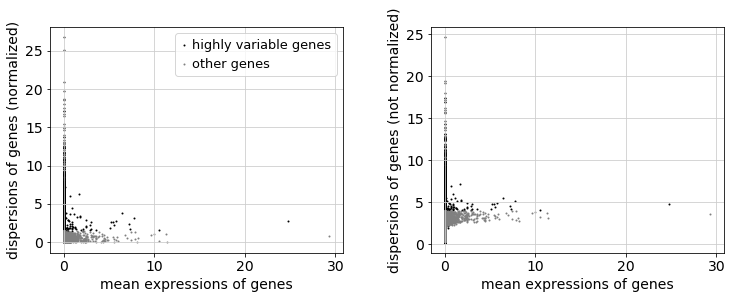

In [15]:
sc.pl.filter_genes_dispersion(filter_result, log=True)

Need to redefine the adata object here before filtering since we have already normalized by the cell size.

In [16]:
# the full dataset
adata = anndata.AnnData(X = X)
adata.obs['zhengsim_clusters'] = pd.Series(y, dtype="category", index=adata.obs.index)
sc.pp.filter_genes(adata, min_counts=1)  # only consider genes with more than 1 count

filtered out 5432 genes that are detected in less than 1 counts


In [17]:
adata = adata[:, filter_result.gene_subset]  # filter genes

Write this filtered data to a file for easy reading.  Note that the y vector hasn't changed.

In [18]:
adata.write(path + "filtered-splat.h5ad")

Also filter the genes and save that info.

In [19]:
genesRemain = [int(gene) for gene in adata.var.index]
deInfo = np.loadtxt(path + "deGenes.dat")
genes = np.array([gene for gene in deInfo[:,0].astype(int) if gene in genesRemain])
args = [ np.where(deInfo[:,0] == gene)[0] for gene in genes ]
facs = deInfo[:,1][args].flatten()

In [20]:
facs.shape

(477,)

In [21]:
np.savez(path + "filtered-splat-deInfo", genes=genes, facs=facs)

In this example data set, only ~500 of the ~3200 differentially expressed genes are saved by this normalization procedure.  It is foolish to look at recall in the full data set (without the filtering), but it still might be good to see the clustering error rates.